# First shot
The purpose of this notebook is to get a quick and dirty model up and running.  It looks like most people used a decision tree but I am going to try logistical regression just to see what I am going to get... A question that I have is that I dont know how a logistic regression model will work with both categorical and quatitative features so I am going to make two models, one with only categorical features and one with both.

In [18]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_raw = pd.read_csv('./train.csv', header=0)
data_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Feature Selection
Check for collumns with null values. 

In [3]:
pd.isnull(data_raw).sum() > 0

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Lets explore Embarked

In [4]:
pd.isnull(data_raw['Embarked']).sum()

2

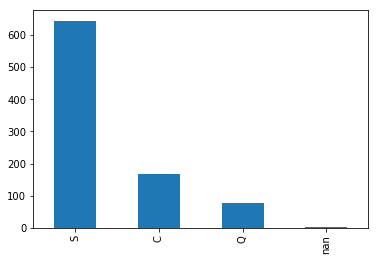

In [5]:
embarked = data_raw['Embarked'].value_counts(dropna=False)
embarked.plot.bar()

plt.show()

The only feature with null values that fits our criteria for the reduced model is Embarked but it has few values so we have a few options as how to handle this. Since it is a non-linear discrete feature and there are few missing entries, we could consider nan as its own label. The other option would be to assign it to the majority class. Since there are only 2, we will leave it as its own label.

Now lets look at age.

Number of missing rows:  177
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


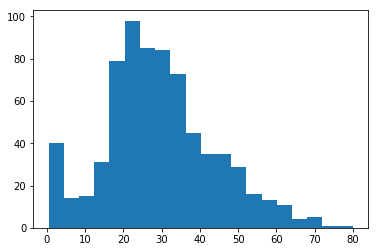

In [6]:
print('Number of missing rows: ', pd.isnull(data_raw['Age']).sum())
age = data_raw['Age'].dropna()
print(age.describe())
plt.hist(age, bins='auto')

plt.show()

This one is more difficult since there are a significant amount of missing data and the data distribution is not normal. It is skewed left and outliers at 0. Since there are so many missing cases I do not want to drop that data.  In addition, I have a little domain knowledge(aka I read some stats about the titatic) and age was a big factor. I think it would be best to input values using the median due to the outliers.

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


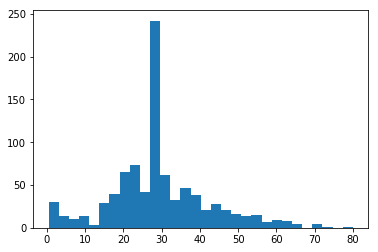

In [7]:
data_raw['Age'] = data_raw['Age'].fillna(age.median())
age = data_raw['Age']
print(age.describe())
plt.hist(age, bins='auto')

plt.show()

After replacing all nans with the median, the data now look pretty bad. I think that this should take some more thought and I am hesitant to use this method but we will proceed.

In [8]:
data_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
feature_labels_reduced = ['Pclass', 'SibSp', 'Parch', 'Sex', 'Embarked']
feature_labels = feature_labels_reduced + ['Fare', 'Age']
output_label = 'Survived'

In [10]:
data_reduced = data_raw[feature_labels_reduced]
data_full = data_raw[feature_labels]
target = data_raw[output_label]

## Feature engineering

Use one-hot encoding to transform non-linear discete features.

In [11]:
data_reduced_matrix = pd.get_dummies(data_reduced, columns=feature_labels_reduced, dummy_na=True)
data_full_matrix =  pd.get_dummies(data_full, columns=feature_labels_reduced, dummy_na=True)

In [12]:
data_full_matrix.columns

Index(['Fare', 'Age', 'Pclass_1.0', 'Pclass_2.0', 'Pclass_3.0', 'Pclass_nan',
       'SibSp_0.0', 'SibSp_1.0', 'SibSp_2.0', 'SibSp_3.0', 'SibSp_4.0',
       'SibSp_5.0', 'SibSp_8.0', 'SibSp_nan', 'Parch_0.0', 'Parch_1.0',
       'Parch_2.0', 'Parch_3.0', 'Parch_4.0', 'Parch_5.0', 'Parch_6.0',
       'Parch_nan', 'Sex_female', 'Sex_male', 'Sex_nan', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Embarked_nan'],
      dtype='object')

## Cross Validation Strategy

For simplicity I am just going to use a simple split for the validation set.  Since we have limited data, in more advanced models I will use K-fold.  Since we have limited data, I will choose a larger training set and use a 80/20 split.

In [17]:
train_reduced, test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    data_reduced_matrix, target, test_size=0.2, random_state=1)
train_full, test_full, y_train_full, y_test_full = train_test_split(
    data_full_matrix, target, test_size=0.2, random_state=1)
print('Number of rows in the training set: ', len(train_full))
print('Number of rows in the validation set: ', len(test_full))

Number of rows in the training set:  712
Number of rows in the validation set:  179


## Building the Model

I will use scikit-learn's [logistic regression model](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [20]:
model_reduced = linear_model.LogisticRegression(penalty='l2', solver='liblinear', random_state=1)
model_full = linear_model.LogisticRegression(penalty='l2', solver='liblinear', random_state=1)
model_reduced.fit(train_reduced, y_train_reduced)
model_full.fit(train_full, y_train_full)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
accuracy_reduced = (model_reduced.predict(test_reduced) == y_test_reduced.as_matrix()).astype(int)
accuracy_reduced = accuracy_reduced.sum() / len(accuracy_reduced)
print('The reduced model produced an accuracy of ', accuracy_reduced)

The reduced model produced an accuracy of  0.765363128492


In [30]:
accuracy_full = (model_full.predict(test_full) == y_test_full.as_matrix()).astype(int)
accuracy_full = accuracy_full.sum() / len(accuracy_full)
print('The full model produced an accuracy of ', accuracy_full)

The full model produced an accuracy of  0.776536312849
